In [39]:
import re
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [40]:
file_path = '../dataset/2021Yan-SP-HEA'
data_file = 'preprocessed.csv'
df = pd.read_csv(f'{file_path}/{data_file}')
num_ftrs = ['k','vm','tm','vac','delta','delta_chi', 'delta_s_mix', 'delta_h_mix']
X = df[num_ftrs]

In [41]:
file = open('../model/RFC_grid.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

binary_est = grid.best_estimator_
clf = binary_est.named_steps['clf']
df['Class_pred'] = np.intc(clf.predict(X))

# Load minmax scaler fit on the training set
with open('../pkl-files/minmax_scaler.pkl', 'rb') as pf:
    minmax = pickle.load(pf)

In [42]:
df.loc[df['no_elements']==5, ['Alloys', 'Class', 'Class_pred']].sample(10, random_state=827)

,Alloys,Class,Class_pred
691,Al1.5Nb1Ti1V1Zr1,0,0
1187,Al.65CoCrFeNi,1,0
456,Al1Cr1Fe1Mo1Ni1,0,0
381,Al1Cr1Fe1Mo0.2Ni1,0,0
177,Al0.9Co1Cu0.9Fe1Ni1,0,0
30,Co1Cu1Fe1Ni1Sn0.04,0,1
1061,CoCrCu0.8FeNi,1,1
733,Al0.3Nb1Ta1Ti1.4Zr1.3,0,0
374,Al1Co1.5Cr1Fe1Mo0.5,0,0
1139,Al.18CoFeNiSi0.15,1,1


In [43]:
grid.best_params_

{'clf__max_depth': 20, 'clf__min_samples_split': 4}

In [44]:
df_copy = df.loc[df['no_elements']==6, :]
df_copy = df[:]

In [45]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
accuracy_score(df_copy['Class'], df_copy['Class_pred'])

0.8756906077348067


0.9728832318760376

<!-- ## Abundance of the chemical elements in earth: 

<p align='left'>
    <img src="../figures/Elemental_abundances.png"  width="600" height="400">
</p> -->

In [46]:
bulk_modulus_data = 'bulk_modulus_added.csv'
df_k = pd.read_csv(f'{file_path}/{bulk_modulus_data}')
with open('../pkl-files/look_up_dict.pkl', 'rb') as pf:
    look_up_dict = pickle.load(pf)
# df_k
# look_up_dict

In [47]:
from mendeleev import element
from qmpy.analysis.miedema import Miedema
from ase.data import atomic_names, atomic_numbers
R = 8.314
def featurization(composition):
    if isinstance(composition, str):
        regex = fr'([A-Z][a-z]*)(\d*\.*\d*?(?=\D|$))'
        patterns = re.findall(regex, composition)
        _composition = [(x, float(y)) if y else (x, 1) for x, y in patterns]
        composition = {}
        for ele, n in _composition:
            composition[ele] = n
    elif not isinstance(composition, dict):
        raise NotImplementedError
    k, vm, tm, vac, avg_chi, avg_ar = np.zeros(6) 
    delta_chi, delta, delta_s_mix, delta_h_mix = np.zeros(4)
    z = sum(composition.values())
    features = {}
    for ele, n in composition.items():
        c = n/z
        k_val = df_k.loc[df_k['atomic_number'] == atomic_numbers[ele]]['bulk_modulus'].values[0]
        k += c*k_val
        vm += c*look_up_dict[ele]['vm'] 
        tm += c*look_up_dict[ele]['tm']
        vac += c*look_up_dict[ele]['vac']
        avg_chi += c*look_up_dict[ele]['chi']
        avg_ar += c*look_up_dict[ele]['ar']
        delta_s_mix += -c*np.log(c + np.finfo(np.float32).eps)
    delta_s_mix *= R
    for ele, n in composition.items():
        c = n/z
        delta_chi += c * (look_up_dict[ele]['chi'] - avg_chi) ** 2
        delta += c * (1-look_up_dict[ele]['ar']/avg_ar) ** 2
    delta_chi = np.sqrt(delta_chi)
    delta = 100 * np.sqrt(delta)
    keys, values = list(composition.keys()), list(composition.values())
    for i, (ele_a, n_a) in enumerate(zip(keys, values)):
        for ele_b, n_b in zip(keys[i+1:], values[i+1:]):
            obj = Miedema({ele_a:1, ele_b:1})
            try:
                delta_H_ab = obj.H_mix
            except AttributeError:
                delta_H_ab = 0
            delta_h_mix += delta_H_ab * n_a * n_b / (z**2)
    delta_h_mix *= 4
    features['k'] = k 
    features['vm'] = vm 
    features['tm'] = tm 
    features['vac'] = vac 
    features['delta'] = delta 
    features['delta_chi'] = delta_chi 
    features['delta_s_mix'] = delta_s_mix 
    features['delta_h_mix'] = delta_h_mix 
    return features

In [48]:
# df.iloc[346, :]

In [49]:
# features = featurization('Co25Cu10Fe10Mo45Ni10')
# features = featurization('CoCrFeNiMn')
features = featurization('Co25Cu10Fe10Mo45Ni10')
df_test = pd.DataFrame(features, index=[0])
df_scaled = minmax.transform(df_test)

In [50]:
_y_pred = clf.predict(df_scaled)


In [51]:
base_elements = ['Ni', 'Fe', 'Cr', 'Co', 'Al', 'Ti', 'Mo', 'Cu']
# base_elements = ['Ni', 'Fe', 'Cr', 'Co', 'Al', 'Ti', 'Mo', 'Cu', 'Mg']
for i in range(2, len(base_elements)):
    formula = ''.join(base_elements[:i])
    features = featurization(formula)
    df_test = pd.DataFrame(features, index=[0])
    df_scaled = minmax.transform(df_test)
    _y_pred = clf.predict(df_scaled)
    if _y_pred:
        print(f'{formula}: single phase.')
    else:
        print(f'{formula} : multiple phase.')

NiFe: single phase.
NiFeCr: single phase.
NiFeCrCo: single phase.
NiFeCrCoAl: single phase.
NiFeCrCoAlTi : multiple phase.
NiFeCrCoAlTiMo : multiple phase.


In [52]:
from itertools import combinations
for combo in combinations(base_elements, 5):
    formula = ''.join(combo)
    features = featurization(formula)
    df_test = pd.DataFrame(features, index=[0])
    df_scaled = minmax.transform(df_test)
    _y_pred = clf.predict(df_scaled)
    if _y_pred:
        print(f'{formula} : single phase.')
    else:
        print(f'{formula} : multiple phase.')    

NiFeCrCoAl : single phase.
NiFeCrCoTi : single phase.
NiFeCrCoMo : multiple phase.
NiFeCrCoCu : single phase.
NiFeCrAlTi : multiple phase.
NiFeCrAlMo : multiple phase.
NiFeCrAlCu : multiple phase.
NiFeCrTiMo : multiple phase.
NiFeCrTiCu : multiple phase.
NiFeCrMoCu : single phase.
NiFeCoAlTi : multiple phase.
NiFeCoAlMo : multiple phase.
NiFeCoAlCu : multiple phase.
NiFeCoTiMo : multiple phase.
NiFeCoTiCu : multiple phase.
NiFeCoMoCu : single phase.
NiFeAlTiMo : multiple phase.
NiFeAlTiCu : multiple phase.
NiFeAlMoCu : multiple phase.
NiFeTiMoCu : multiple phase.
NiCrCoAlTi : multiple phase.
NiCrCoAlMo : multiple phase.
NiCrCoAlCu : multiple phase.
NiCrCoTiMo : multiple phase.
NiCrCoTiCu : multiple phase.
NiCrCoMoCu : single phase.
NiCrAlTiMo : multiple phase.
NiCrAlTiCu : multiple phase.
NiCrAlMoCu : multiple phase.
NiCrTiMoCu : multiple phase.
NiCoAlTiMo : multiple phase.
NiCoAlTiCu : multiple phase.
NiCoAlMoCu : multiple phase.
NiCoTiMoCu : multiple phase.
NiAlTiMoCu : multiple phas

In [53]:
from itertools import product

CrCoNi_range = np.arange(15, 21)
Mo_range = np.arange(0, 15, step=1)
comp_ftrs = {'Alloy':[], 'Co':[], 'Cr':[], 'Ni':[], 'Mo':[]}
target_ftr = {'class_pred': []}

# Corrosion-resistant elements
elements = ['Fe', 'Cr', 'Co', 'Ni', 'Mo']
sum_up = 100
# Cr, Co, Ni limited to [15, 21), the balance will be Fe
# Cr is limited to [0, 15)
# for no_Cr, no_Co, no_Ni, no_Mo in product(CrCoNi_range, CrCoNi_range, CrCoNi_range, Mo_range):
for no_Mo in Mo_range:
    formula = ''
    no_Cr = no_Ni = no_Co = (100 - no_Mo) // 4
    no_Fe = sum_up - no_Cr - no_Co - no_Ni - no_Mo
    formula += 'Co' + str(no_Co)
    formula += 'Cr' + str(no_Cr)
    formula += 'Ni' + str(no_Ni)
    formula += 'Mo' + str(no_Mo)
    formula += 'Fe' + str(no_Fe)
    features = featurization(formula)
    df_test = pd.DataFrame(features, index=[0])
    df_scaled = minmax.transform(df_test)
    _y_pred = clf.predict(df_scaled)[0]
    comp_ftrs['Co'].append(no_Co)
    comp_ftrs['Cr'].append(no_Cr)
    comp_ftrs['Ni'].append(no_Ni)
    comp_ftrs['Mo'].append(no_Mo)
    comp_ftrs['Alloy'].append(formula)
    target_ftr['class_pred'].append(_y_pred)

In [54]:
df_dict = comp_ftrs.copy()
df_dict.update(target_ftr)
df = pd.DataFrame(df_dict)
df['class_pred'].value_counts()

class_pred
1    12
0     3
Name: count, dtype: int64

In [55]:
df

,Alloy,Co,Cr,Ni,Mo,class_pred
0,Co25Cr25Ni25Mo0Fe25,25,25,25,0,1
1,Co24Cr24Ni24Mo1Fe27,24,24,24,1,1
2,Co24Cr24Ni24Mo2Fe26,24,24,24,2,1
3,Co24Cr24Ni24Mo3Fe25,24,24,24,3,1
4,Co24Cr24Ni24Mo4Fe24,24,24,24,4,1
5,Co23Cr23Ni23Mo5Fe26,23,23,23,5,1
6,Co23Cr23Ni23Mo6Fe25,23,23,23,6,1
7,Co23Cr23Ni23Mo7Fe24,23,23,23,7,1
8,Co23Cr23Ni23Mo8Fe23,23,23,23,8,1
9,Co22Cr22Ni22Mo9Fe25,22,22,22,9,1


In [81]:
from itertools import product

CrCoNi_range = np.arange(15, 21)
Al_range = np.arange(0, 26, step=1)
Cr_range = np.arange(10, 31, step=1)
comp_ftrs = {'Alloy':[], 'Co':[], 'Cr':[], 'Ni':[], 'Al':[]}
target_ftr = {'class_pred': []}

# Corrosion-resistant elements
elements = ['Fe', 'Cr', 'Co', 'Ni', 'Al']
sum_up = 100
# Cr, Co, Ni limited to [15, 21), the balance will be Fe
# Cr is limited to [0, 15)
als, crs = [], []
res = []
for no_Al in Al_range:
    for no_Cr in Cr_range:
        als.append(no_Al)
        crs.append(no_Cr)
        formula = ''
        no_Co = no_Ni = no_Fe = (100 - no_Al -no_Cr) / 3
    #     no_Fe = sum_up - no_Cr - no_Co - no_Ni - no_Al
        formula += 'Co' + str(no_Co)
        formula += 'Cr' + str(no_Cr)
        formula += 'Ni' + str(no_Ni)
        formula += 'Al' + str(no_Al)
        formula += 'Fe' + str(no_Fe)
        features = featurization(formula)
        df_test = pd.DataFrame(features, index=[0])
        df_scaled = minmax.transform(df_test)
        _y_pred = clf.predict(df_scaled)[0]
        comp_ftrs['Co'].append(no_Co)
        comp_ftrs['Cr'].append(no_Cr)
        comp_ftrs['Ni'].append(no_Ni)
        comp_ftrs['Al'].append(no_Al)
        comp_ftrs['Alloy'].append(formula)
        target_ftr['class_pred'].append(_y_pred)
        res.append(_y_pred)

In [82]:
# df_dict = comp_ftrs.copy()
# df_dict.update(target_ftr)
# df = pd.DataFrame(df_dict)
# df['class_pred'].value_counts()
# df.sample(n=50)

In [83]:
def get_al_per(row):
    alloy_sep = row['alloy_sep']
    z = row['normalizer']
    for ele, n in alloy_sep:
        if ele == 'Al':
            al_per = 100/z * n 
    return al_per

def get_cr_per(row):
    alloy_sep = row['alloy_sep']
    z = row['normalizer']
    for ele, n in alloy_sep:
        if ele == 'Cr':
            cr_per = 100/z * n 
    return cr_per

In [84]:
file_path = '../dataset/2021Yan-SP-HEA'
data_file = 'inconsistency.csv'
df = pd.read_csv(f'{file_path}/{data_file}')
df.drop('Phase', inplace=True, axis=1)
regex = fr'([A-Z][a-z]*)(\d*\.*\d*?(?=\D|$))'
df['alloy_sep'] = df['Alloy'].str.findall(regex)
df['alloy_sep'] = df['alloy_sep'].apply(lambda m: [(x, float(y)) if y else (x, 1) for x, y in m])
df['no_elements'] = df['alloy_sep'].apply(lambda m: sum([1 for _ in m]))
df['normalizer'] = df['alloy_sep'].apply(lambda m: sum([_[1] for _ in m]))
df.drop(df[df['no_elements'] > 5].index, inplace=True)
df['al_per'] = df.apply(lambda row: get_al_per(row), axis=1)
df['cr_per'] = df.apply(lambda row: get_cr_per(row), axis=1)
df = df[['al_per', 'cr_per', 'Class']]
# print(df.stackcribe())
_al_pers, _cr_pers, labels = df['al_per'].values, df['cr_per'].values, df['Class'].values
df.sample(5)

,al_per,cr_per,Class
33,30.795848,17.301038,0
19,19.191919,20.202020,0
11,14.893617,21.276596,0
4,10.112360,22.471910,0
14,16.666667,20.833333,0


In [85]:
_predicted = []
_labels = []
count = 0
for al_per, cr_per, label in zip(_al_pers, _cr_pers, labels):
        if al_per > 25 or cr_per < 10 or cr_per > 30:
            continue
        formula = ''
        no_Al = al_per
        no_Cr = cr_per
        no_Co = no_Ni = no_Fe = (100 - no_Al -no_Cr) / 3
    #     no_Fe = sum_up - no_Cr - no_Co - no_Ni - no_Al
        formula += 'Co' + str(no_Co)
        formula += 'Cr' + str(no_Cr)
        formula += 'Ni' + str(no_Ni)
        formula += 'Al' + str(no_Al)
        formula += 'Fe' + str(no_Fe)
        features = featurization(formula)
        df_test = pd.DataFrame(features, index=[0])
        df_scaled = minmax.transform(df_test)
        _y_pred = clf.predict(df_scaled)[0]
        _predicted.append(_y_pred)
        _labels.append(label)
        count += label == _y_pred
        print(int(al_per), int(cr_per), _y_pred, label)
score = accuracy_score(_predicted, _labels)
print(len(_predicted), count)
print(score)

8 22 0 0
10 22 0 0
10 18 1 0
12 21 0 0
13 21 0 0
13 21 0 0
14 21 0 0
15 21 0 0
16 20 0 0
17 20 0 0
17 20 0 0
19 20 0 0
19 20 0 0
21 19 0 0
22 19 0 0
23 19 0 0
23 19 0 0
24 18 0 0
0 25 1 1
2 24 1 1
2 24 1 1
2 24 1 1
3 24 1 1
4 23 1 1
5 23 1 1
5 23 1 1
6 23 1 1
8 22 1 1
8 22 1 1
9 22 1 1
11 22 1 1
13 21 0 1
18 20 1 1
17 25 0 1
20 20 1 1
35 32
0.9142857142857143


In [86]:
print(len(labels), len(_al_pers), len(_cr_pers))

57 57 57


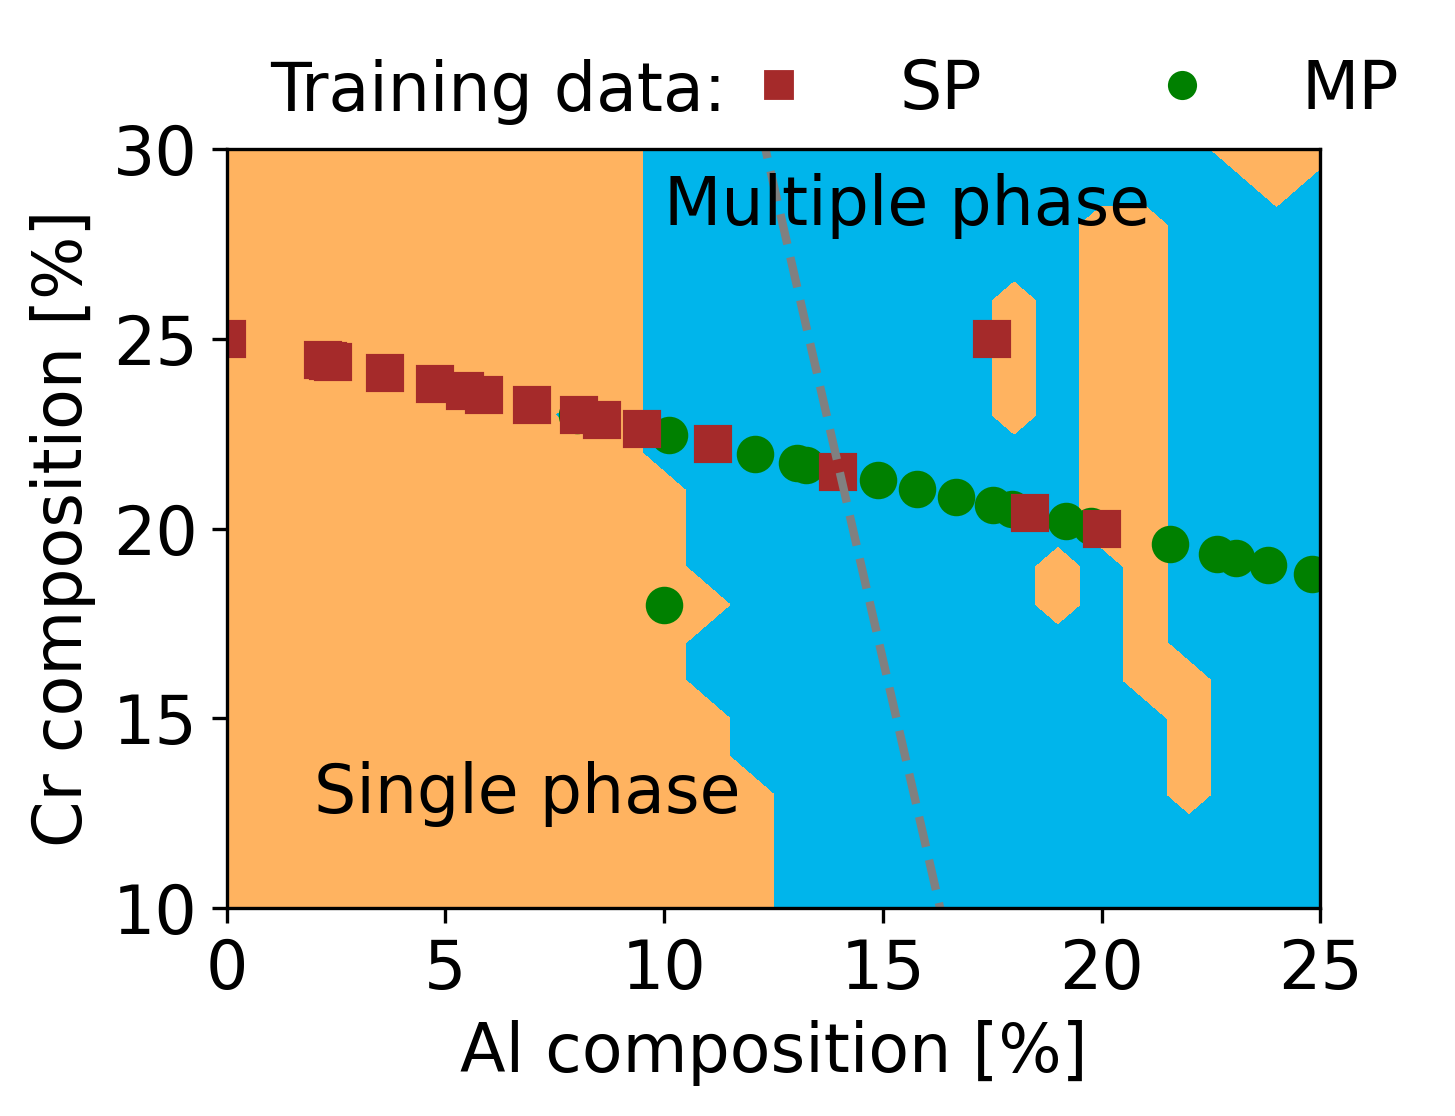

In [98]:
import matplotlib
font = {'size': 16}
matplotlib.rc('font', **font)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


al_pers = Al_range
cr_pers = Cr_range
X = np.array(als).reshape((len(al_pers), len(cr_pers)))
Y = np.array(crs).reshape((len(al_pers), len(cr_pers)))
Z = np.array(res).reshape((len(al_pers), len(cr_pers)))
fig,ax=plt.subplots(1,1, figsize=(5,4), dpi=300)
cp = ax.contourf(X, Y, Z, levels=1, cmap='rainbow')
ax.text(2, 12.5, r'Single phase', color='k', fontsize=16)
ax.text(10, 28, r'Multiple phase', color='k', fontsize=16)
ax.set_xticks(np.arange(0, 26, step=5))
ax.set_yticks(np.arange(10, 31, step=5))

for al_per, cr_per, label in zip(_al_pers, _cr_pers, labels):
#     print(label)
    if al_per > 25 or cr_per < 10 or cr_per > 30:
        continue
    if int(label) == 1:
        ax.plot(al_per, cr_per, 's', markersize=8, color='brown')
    elif label == 0:
        ax.plot(al_per, cr_per, 'o', markersize=8, color='green')

xs = np.array([13.11, 16.24])
ys = [26.03, 10.35]
ps = np.polyfit(xs, ys, 1)
m, b = ps
# print(m, b)
_xs = np.array([8, 20])
ax.plot(_xs, m*_xs+b, ls='--', lw=2, color='grey')
        
ax.set_xlabel('Al composition [%]')
ax.set_xlim([0, 25])
ax.set_ylim([10, 30])
ax.set_ylabel('Cr composition [%]')

## custom legend
legend_elements = [Line2D([0], [0], marker='s', color='w', label='SP',
                         markerfacecolor='brown', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='MP',
                          markerfacecolor='g', markersize=8)]
#                    Patch(facecolor='orange', edgecolor='r',
#                          label='Color Patch')]
ax.legend(handles=legend_elements, loc=(0.42, 1.00), ncol=2, frameon=False)
ax.text(1, 31, r'Training data:', color='k', fontsize=16)
plt.tight_layout()
plt.savefig('../figures/sp_or_mp.pdf')

In [24]:
# import pandas as pd
# import plotly
# import plotly.graph_objs as go

# #Set marker properties
# markercolor = df['Co']
# markersize = df['class_pred']

# #Make Plotly figure
# fig1 = go.Scatter3d(x=df['Mo'],
#                     y=df['Cr'],
#                     z=df['Ni'],
#                     marker=dict(color=markercolor,
#                                 size=20*markersize,
#                                 opacity=1,
#                                 reversescale=True,
#                                 colorscale='Blues',
#                                 ),
#                     line=dict(width=0.02),
#                     mode='markers')

# #Make Plot.ly Layout
# mylayout = go.Layout(scene=dict(xaxis=dict(title=r"c$_{\rm{Mo}}$"),
#                                 yaxis=dict(title=r"c$_{\rm{Cr}}$"),
#                                 zaxis=dict(title=r"c$_{\rm{Ni}}$")),)

# #Plot and save html
# plotly.offline.plot({"data": [fig1],
#                      "layout": mylayout},
#                      auto_open=True,
#                      filename=("../figures/SP_FeCoCrNiMo.png"))

In [25]:
# from itertools import product

# CrTiNi_range = np.arange(15, 21)
# Mo_range = np.arange(0, 15, step=1)
# comp_ftrs = {'Alloy':[], 'Ti':[], 'Cr':[], 'Ni':[], 'Mo':[]}
# target_ftr = {'class_pred': []}

# # Tirrosion-resistant elements
# elements = ['Fe', 'Cr', 'Ti', 'Ni', 'Mo']
# sum_up = 100
# # Cr, Ti, Ni limited to [15, 21), the balance will be Fe
# # Cr is limited to [0, 15)
# for no_Cr, no_Ti, no_Ni, no_Mo in product(CrTiNi_range, CrTiNi_range, CrTiNi_range, Mo_range):
#     formula = ''
#     no_Fe = sum_up - no_Cr - no_Ti - no_Ni - no_Mo
#     formula += 'Ti' + str(no_Ti)
#     formula += 'Cr' + str(no_Cr)
#     formula += 'Ni' + str(no_Ni)
#     formula += 'Mo' + str(no_Mo)
#     formula += 'Fe' + str(no_Fe)
#     features = featurization(formula)
#     df_test = pd.DataFrame(features, index=[0])
#     df_scaled = minmax.transform(df_test)
#     _y_pred = clf.predict(df_scaled)[0]
#     comp_ftrs['Ti'].append(no_Ti)
#     comp_ftrs['Cr'].append(no_Cr)
#     comp_ftrs['Ni'].append(no_Ni)
#     comp_ftrs['Mo'].append(no_Mo)
#     comp_ftrs['Alloy'].append(formula)
#     target_ftr['class_pred'].append(_y_pred)

In [26]:
# df_dict = comp_ftrs.copy()
# df_dict.update(target_ftr)
# df = pd.DataFrame(df_dict)
# df['class_pred'].value_counts()

In [27]:
# df.sample(20)

In [28]:
# #Set marker properties
# markercolor = df['Ti']
# markershape = df['class_pred'].replace(1, 'square').replace(0, 'circle')

# #Make Plotly figure
# fig1 = go.Scatter3d(x=df['Mo'],
#                     y=df['Cr'],
#                     z=df['Ni'],
#                     marker=dict(color=markercolor,
#                                 size=10,
#                                 symbol=markershape,
#                                 opacity=1,
#                                 reversescale=True,
#                                 colorscale='Blues',
#                                 ),
#                     line=dict(width=0.02),
#                     mode='markers')

# #Make Plot.ly Layout
# mylayout = go.Layout(scene=dict(xaxis=dict(title=r"c$_{\rm{Mo}}$"),
#                                 yaxis=dict(title=r"c$_{\rm{Cr}}$"),
#                                 zaxis=dict(title=r"c$_{\rm{Ni}}$")),)

# #Plot and save html
# plotly.offline.plot({"data": [fig1],
#                      "layout": mylayout},
#                      auto_open=True,
#                      filename=("../figures/SP_FeTiCrNiMo.png"))